In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cp_common import process_price_data as cpc
from cp_scratch import network_fundamentals as cpsn
from cp_scratch import basic_functions as cpsb
%matplotlib inline

Might wanna later change all calculations to GPU

In [2]:
mean, std, pd_Xtrain, pd_ytrain, pd_Xtest, pd_ytest, Xtrain, ytrainOrig, Xtest, ytestOrig = cpc.return_data()

Loaded BCHARTS/BITFINEXUSD from cache
Loaded BCHARTS/COINBASEUSD from cache


In [3]:
ytrain = cpsb.convert_to_one_hot(ytrainOrig, 9)
ytest = cpsb.convert_to_one_hot(ytestOrig, 9)

In [4]:
print(Xtrain.shape)
print(ytrainOrig.shape)
print(ytrain.shape)
print()
print(Xtest.shape)
print(ytestOrig.shape)
print(ytest.shape)

(7, 1500)
(1, 1500)
(9, 1500)

(7, 156)
(1, 156)
(9, 156)


In [5]:
def performNN(X, y, network, learning_rate, iterations, lambd, debug=0):
    
    parameters = cpsn.initialize_parameters(network, debug=1)
    amount = len(parameters) // 2
    costs = []
    
    for i in range(0,iterations):
        cache, AL = cpsn.forward_propagation(X, parameters)
        cost = cpsn.cost_function(AL, y, lambd, parameters)
        costs.append(cost)
        
        if (debug == 1):
            if (i % 500 == 0):
                print("Cost after {} iterations is: {}".format(i, cost))
        
        grads = cpsn.back_propagation(X, y, cache, parameters, lambd)
        
        for j in range(1,amount+1):
            parameters['W' + str(j)] = parameters['W' + str(j)] - learning_rate * grads['dW' + str(j)]
            parameters['b' + str(j)] = parameters['b' + str(j)] - learning_rate * grads['db' + str(j)]
    
    if (debug == 1):
        #plot costs with number of iterations
        cpsb.single_plot(costs, 'Iterations VS Cost', 'Number of Iterations', 'Cost')
        print("Final Cost: " + str(costs[-1]))
    
    return costs, parameters, cache; #parameters is needed to compute forward_propage for other values of X

In [6]:
def performAdvNN(X, y, network, learning_rate , iterations, lambd, nntype='gd', batch_size=64, debug=0, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    parameters = cpsn.initialize_parameters(network)
    amount = len(parameters) // 2
    costs = []
    mini_batches = cpsb.initialize_mini_batch(X, y, batch_size)
    
    t=0
    
    if nntype=='adam':
        v, s = cpsb.initialize_adam(parameters)
        v_corrected={}
        s_corrected={}
    
    for i in range(0,iterations):
        for batch in mini_batches:
            (Xbatch, ybatch) = batch
            
            cache,AL = cpsn.forward_propagation(Xbatch, parameters)
            grads = cpsn.back_propagation(Xbatch, ybatch, cache, parameters, lambd)
            
            for j in range(1,amount+1):
                if (nntype == 'gd'):
                    parameters['W' + str(j)] = parameters['W' + str(j)] - learning_rate * grads['dW' + str(j)]
                    parameters['b' + str(j)] = parameters['b' + str(j)] - learning_rate * grads['db' + str(j)]
                elif (nntype == 'adam'):
                    v['dW' + str(j)] = beta1 * v['dW' + str(j)] + (1-beta1) * grads['dW' + str(j)]
                    v['db' + str(j)] = beta2 * v['db' + str(j)] + (1-beta1) * grads['db' + str(j)]
                    t = t + 1 #Reset?
                    
                    v_corrected['dW' + str(j)] = v['dW' + str(j)] / (1-(beta1 ** t))
                    v_corrected['db' + str(j)] = v['db' + str(j)] / (1-(beta1 ** t))
                    
                    s['dW' + str(j)] = beta2 * s['dW' + str(j)] + (1-beta2) * (grads['dW' + str(j)] ** 2)
                    s['db' + str(j)] = beta2 * s['db' + str(j)] + (1-beta2) * (grads['db' + str(j)] ** 2)
                    
                    s_corrected['dW' + str(j)] = s['dW' + str(j)] / (1-(beta2 ** t))
                    s_corrected['db' + str(j)] = s['db' + str(j)] / (1-(beta2 ** t))
                    
                    parameters['W' + str(j)] = parameters['W' + str(j)] - (learning_rate * (v_corrected['dW' + str(j)] / (np.sqrt(s_corrected['dW' + str(j)] + epsilon))))
                    parameters['b' + str(j)] = parameters['b' + str(j)] - (learning_rate * (v_corrected['db' + str(j)] / (np.sqrt(s_corrected['db' + str(j)] + epsilon))))
        
        cache,AL = cpsn.forward_propagation(X, parameters)
        cost = cpsn.cost_function(AL, y, lambd, parameters)
        costs.append(cost)
        
        if (debug == 1):
            if (i % 500 == 0):
                print("Cost after {} iterations is: {}".format(i, cost))
        
    if (debug == 1):
        cpsb.single_plot(costs, 'Iterations VS Cost', 'Number of Iterations', 'Cost')
        print("Final Cost: " + str(costs[-1]))
        
    return costs, parameters; #parameters is needed to compute forward_propage for other values of X 

Cost after 0 iterations is: 2.2730379063678154
Cost after 500 iterations is: 2.177916917378351
Cost after 1000 iterations is: 2.1243391926713757
Cost after 1500 iterations is: 2.091360545556585
Cost after 2000 iterations is: 2.0659421483150022
Cost after 2500 iterations is: 2.046060147701969
Final Cost: 2.0310379826639258


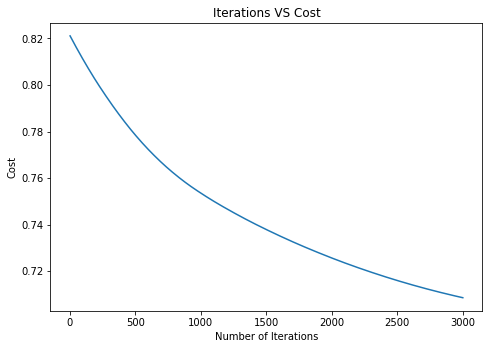

In [7]:
costs,param,cache = performNN(Xtrain, ytrain, [7, 8, 5, 9], 0.0007, 3000, 0.01, debug=1) #do sth about the cost function then add random seed.

Cost after 0 iterations is: 2.2161587979658157
Final Cost: 2.19722457729679


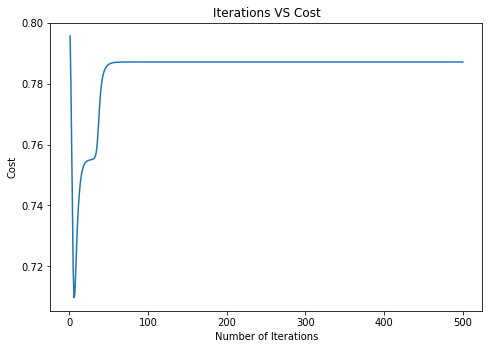

In [8]:
costs,adamParam = performAdvNN(Xtrain, ytrain, [7, 8, 5, 9], 0.0007, 500, 0, nntype='adam' , debug=1) #do sth about the cost function then add random seed.

In [9]:
def calculate_accuracy(X, y, params):
    cache, AL = cpsn.forward_propagation(X, params)
    y, AL = y.T, AL.T
    
    yVals = y.argmax(axis=1) - 4
    ALpred = AL.argmax(axis=1) - 4
    
    accurate = np.sum(yVals == ALpred)
    accuracy = accurate/yVals.shape[0]
    print("Accuracy: " + str(accuracy))
    print("Accuracy if all zero predicted:" + str(np.sum(yVals == 0)/yVals.shape[0]))
    
    print("\nValues and their occurance:")
    
    for i in range(-4,5):
        print("Number: " + str(i))
        print("Occurance in Data:" +  str(np.sum(yVals == i)))
        print("Occurance in Prediction:" +  str(np.sum(ALpred == i)))
        print()

In [10]:
calculate_accuracy(Xtrain, ytrain, param)

Accuracy: 0.688
Accuracy if all zero predicted:0.746

Values and their occurance:
Number: -4
Occurance in Data:5
Occurance in Prediction:0

Number: -3
Occurance in Data:20
Occurance in Prediction:0

Number: -2
Occurance in Data:62
Occurance in Prediction:0

Number: -1
Occurance in Data:73
Occurance in Prediction:0

Number: 0
Occurance in Data:1119
Occurance in Prediction:1304

Number: 1
Occurance in Data:101
Occurance in Prediction:0

Number: 2
Occurance in Data:89
Occurance in Prediction:196

Number: 3
Occurance in Data:24
Occurance in Prediction:0

Number: 4
Occurance in Data:7
Occurance in Prediction:0



In [11]:
calculate_accuracy(Xtrain, ytrain, adamParam)

Accuracy: 0.013333333333333334
Accuracy if all zero predicted:0.746

Values and their occurance:
Number: -4
Occurance in Data:5
Occurance in Prediction:0

Number: -3
Occurance in Data:20
Occurance in Prediction:1500

Number: -2
Occurance in Data:62
Occurance in Prediction:0

Number: -1
Occurance in Data:73
Occurance in Prediction:0

Number: 0
Occurance in Data:1119
Occurance in Prediction:0

Number: 1
Occurance in Data:101
Occurance in Prediction:0

Number: 2
Occurance in Data:89
Occurance in Prediction:0

Number: 3
Occurance in Data:24
Occurance in Prediction:0

Number: 4
Occurance in Data:7
Occurance in Prediction:0

